Unravelling with the V-model with just one bath

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from _utils import *
from FCS import *

In [5]:
# Define system parameters
N = 3 # Number of levels
nu = 1 # Frequency of the system
a = 0.01 
delta = 0.01
# alpha = 0.5 # No right bath for now
betaL = 1/4
# betaR = 1/3.99 # No right bath for now

# Define the parameters for the V-model
params = {'nu': nu, 'a': a, 'delta': delta, 'beta': betaL}

# Set up the open system problem with one bath at temperature 1/betaL
g_ops, H_uni, c_ops_uni = V_model_1bath(**params, kind='unified')
g_ops, H_sec, c_ops_sec = V_model_1bath(**params, kind='secular')

# Define the steady state density operators
rho_ss_uni = steadystate(H_uni, c_ops_uni)
rho_ss_sec = steadystate(H_sec, c_ops_sec)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[3.90991315e-01+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 3.04504342e-01+0.00000000e+00j
  1.08412737e-16+2.48264819e-17j]
 [0.00000000e+00+0.00000000e+00j 1.08412737e-16-2.48264819e-17j
  3.04504342e-01+0.00000000e+00j]]

In [13]:
# We want to unravel the master equation

t0, tf = 0, 225
dt = 0.01
tlist = np.arange(t0, tf, dt)

g1, g2, g3 = g_ops

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H_uni, rho_ss_uni, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)
result_sec = photocurrent_mesolve(H_sec, rho_ss_sec, tlist, sc_ops=c_ops_sec, e_ops=e_ops, ntraj=1, noise=1, store_measurement=True)

Total run time:   0.26s
Total run time:   0.28s


In [14]:
# Get all the expectation values
g1_evo_uni = result_uni.expect[0]
g2_evo_uni = result_uni.expect[1]
g3_evo_uni = result_uni.expect[2]
g32_evo_uni = result_uni.expect[3]

g1_evo_sec = result_sec.expect[0]
g2_evo_sec = result_sec.expect[1]
g3_evo_sec = result_sec.expect[2]
g32_evo_sec = result_sec.expect[3]

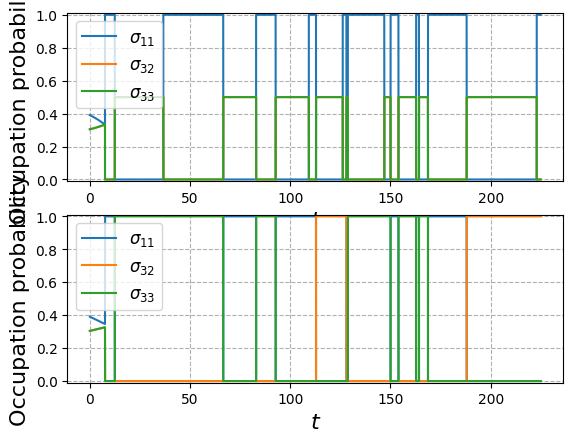

In [15]:
# Plot the populations

plt.subplot(211)
plt.plot(tlist, g1_evo_uni, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_uni, label=r'$\sigma_{32}$') 
plt.plot(tlist, g3_evo_uni, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g1_evo_sec, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_sec, label=r'$\sigma_{32}$') 
plt.plot(tlist, g3_evo_sec, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

In [ ]:
# Plot the coherences

plt.subplot(211)
plt.plot(tlist, g32_evo_uni, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g32_evo_sec, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()